In [312]:
import re
import numpy as np
import pandas as pd


In [313]:
# Define your local path
base_path = r"C:\Users\alons\OneDrive - Cornell University\Cornell University\Spring 2025\CFEM Research Assistant\Parser\royalty_scraper"

# Files to load
files = {
    "offers": "offers_total.csv",
    "financials": "financials_totals.csv",
    "revenues_deals": "revenues_and_deals.csv"
}

# Load files into DataFrames
dataframes = {}
for key, filename in files.items():
    file_path = os.path.join(base_path, filename)
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded {filename} with shape: {df.shape}")
        dataframes[key] = df
    except Exception as e:
        print(f"Failed to load {filename}: {e}")


Loaded offers_total.csv with shape: (23097, 7)
Loaded financials_totals.csv with shape: (1014, 33)
Failed to load revenues_and_deals.csv: [Errno 2] No such file or directory: 'C:\\Users\\alons\\OneDrive - Cornell University\\Cornell University\\Spring 2025\\CFEM Research Assistant\\Parser\\royalty_scraper\\revenues_and_deals.csv'


In [314]:

# Copy financials data
fin_df = dataframes['financials'].copy()

# Clean and extract numeric multiplier from 'LTM Multiple'
def extract_multiplier(val):
    if pd.isnull(val):
        return np.nan
    # Use regex to extract float before 'x'
    match = re.search(r"(\d+\.?\d*)", str(val))
    return float(match.group(1)) if match else np.nan

# Rename columns for consistency
fin_df = fin_df.rename(columns={
    'Listing ID': 'listing_id',
    'Last 12 Months': 'LTM',
    'Years Remaining': 'time_to_maturity',
    'Last Transaction Date': 'transaction_date'
})

# Convert types and handle missing values
fin_df['LTM'] = pd.to_numeric(fin_df['LTM'], errors='coerce')
fin_df['transaction_date'] = pd.to_datetime(fin_df['transaction_date'], errors='coerce')
fin_df['multiplier'] = fin_df['LTM Multiple'].apply(extract_multiplier)
fin_df = fin_df.dropna(subset=['LTM', 'multiplier'])

# Compute log(LTM)
fin_df['log_LTM'] = np.log(fin_df['LTM'])
# Drop rows with missing LTM
fin_df = fin_df.dropna(subset=['LTM'])

# Compute log(LTM)
fin_df['log_LTM'] = np.log(fin_df['LTM'])

# Clean `time_to_maturity`
def clean_time_to_maturity(val):
    if pd.isnull(val):
        return np.nan
    val = str(val).lower().strip()
    if 'life' in val:
        return 70.0
    digits = ''.join(c for c in val if c.isdigit() or c == '.')
    return float(digits) if digits else np.nan

fin_df['time_to_maturity_clean'] = fin_df['time_to_maturity'].apply(clean_time_to_maturity)

fin_df['time_to_maturity_clean'] = fin_df['time_to_maturity'].apply(
    lambda x: 70 if isinstance(x, str) and 'life' in x.lower() else x
)

# Final preview
print("Cleaned financials dataset preview:")
print(fin_df[['listing_id', 'multiplier', 'LTM', 'log_LTM', 'transaction_date', 'time_to_maturity_clean']].head())


Cleaned financials dataset preview:
   listing_id  multiplier      LTM    log_LTM transaction_date  \
0        5699        5.80   4277.0   8.361007       2024-05-17   
1        5677        4.84   4534.0   8.419360              NaT   
2        5757        5.15   1262.0   7.140453              NaT   
3        5714        8.83  22087.0  10.002744              NaT   
4        5697        5.25   1500.0   7.313220              NaT   

  time_to_maturity_clean  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                     30  


In [315]:
# Step 1: Prepare offers_filled with datetime cleaned
offers_df = dataframes['offers'].copy()
offers_df = offers_df.rename(columns={
    'Listing ID': 'listing_id',
    'multiple': 'multiplier'
})
offers_df['multiplier'] = pd.to_numeric(offers_df['multiplier'], errors='coerce')
offers_df['timestamp'] = pd.to_datetime(offers_df['timestamp'], errors='coerce').dt.date

# Filter only filled offers
offers_filled = offers_df[offers_df['state'].str.lower() == 'filled']

# Step 2: Prepare financials transaction_date
fin_df['transaction_date'] = pd.to_datetime(fin_df['transaction_date'], errors='coerce').dt.date

# Step 3: Merge for substitution
fin_df = pd.merge(
    fin_df,
    offers_filled[['listing_id', 'multiplier', 'timestamp']],
    on=['listing_id', 'multiplier'],
    how='left'
)

# Step 4: Fill missing transaction_date with timestamp
fin_df['transaction_date'] = fin_df['transaction_date'].fillna(fin_df['timestamp'])

# Step 5: Drop temporary 'timestamp' column
fin_df = fin_df.drop(columns=['timestamp'])
columns_to_keep = [
    'listing_id', 'multiplier', 'LTM', 'log_LTM',
    'transaction_date', 'time_to_maturity_clean'
]

fin_df = fin_df[columns_to_keep]
fin_df

,listing_id,multiplier,LTM,log_LTM,transaction_date,time_to_maturity_clean
0,5699,5.80,4277.0,8.361007,2024-05-17,NaN
1,5677,4.84,4534.0,8.419360,2024-07-16,NaN
2,5757,5.15,1262.0,7.140453,2024-07-10,NaN
3,5714,8.83,22087.0,10.002744,2024-07-09,NaN
4,5697,5.25,1500.0,7.313220,2024-07-09,30
...,...,...,...,...,...,...
612,4593,5.76,2777.0,7.929126,2022-04-15,NaN
613,4582,10.69,982.0,6.889591,2022-04-14,1
614,4590,8.88,796.0,6.679599,2022-04-14,NaN
615,4560,16.28,6448.0,8.771525,2022-04-12,NaN


In [316]:
# Updated fields to check
fields_to_check = ['listing_id', 'multiplier', 'LTM', 'log_LTM', 'transaction_date', 'time_to_maturity_clean']

print("🔍 Updated Data Quality Checks:\n")

for col in fields_to_check:
    if col not in fin_df.columns:
        print(f"❌ Missing column: {col}")
        continue

    non_null = fin_df[col].notnull().sum()
    total = len(fin_df)
    nulls = total - non_null
    percent_missing = (nulls / total) * 100

    print(f"✅ {col}:")
    print(f"   - Non-null values: {non_null:,} / {total:,}")
    print(f"   - Missing: {nulls:,} ({percent_missing:.2f}%)")

    # Type check
    dtype = fin_df[col].dtype
    print(f"   - Data type: {dtype}\n")


🔍 Updated Data Quality Checks:

✅ listing_id:
   - Non-null values: 617 / 617
   - Missing: 0 (0.00%)
   - Data type: int64

✅ multiplier:
   - Non-null values: 617 / 617
   - Missing: 0 (0.00%)
   - Data type: float64

✅ LTM:
   - Non-null values: 617 / 617
   - Missing: 0 (0.00%)
   - Data type: float64

✅ log_LTM:
   - Non-null values: 617 / 617
   - Missing: 0 (0.00%)
   - Data type: float64

✅ transaction_date:
   - Non-null values: 615 / 617
   - Missing: 2 (0.32%)
   - Data type: object

✅ time_to_maturity_clean:
   - Non-null values: 135 / 617
   - Missing: 482 (78.12%)
   - Data type: object



### 1. log_LTM vs. multiplier

Objective: Replicate Umo's finding — lower log(LTM) revenue tends to be associated with higher multipliers.

Plot: Scatterplot (log_LTM on x-axis, multiplier on y-axis)

Add: Linear regression line

Calculate: Correlation coefficient (Pearson's r), R²

Optional: Use bins of log_LTM and plot average multiplier per bin

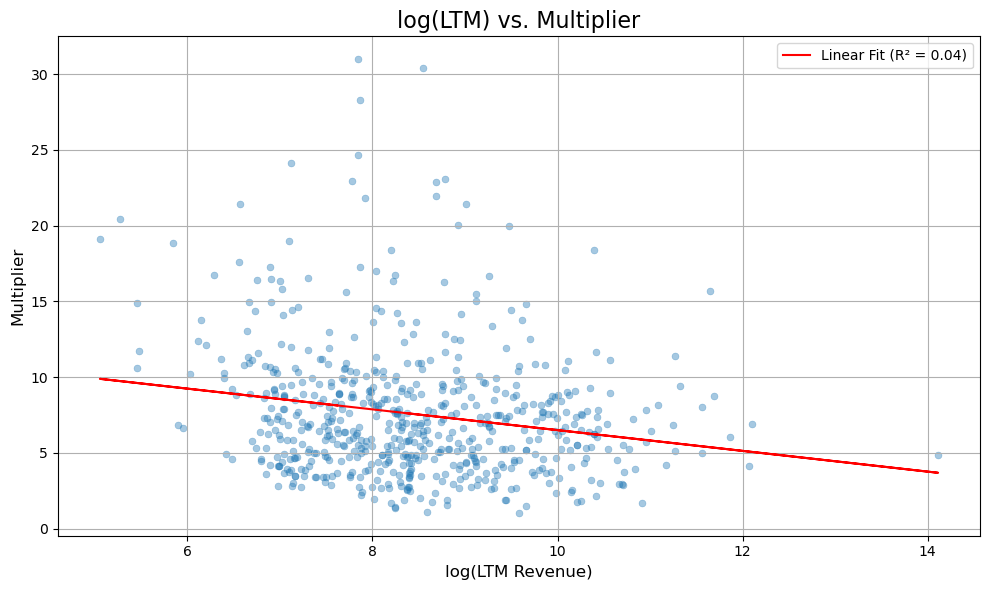

Pearson correlation: -0.196
Regression line: multiplier = -0.685 * log_LTM + 13.353


In [317]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, pearsonr

# Drop rows with missing values in log_LTM or multiplier
df_plot = fin_df.dropna(subset=['log_LTM', 'multiplier'])

# Linear regression stats
slope, intercept, r_value, p_value, std_err = linregress(df_plot['log_LTM'], df_plot['multiplier'])

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='log_LTM', y='multiplier', alpha=0.4, s=25, edgecolor=None)
plt.plot(df_plot['log_LTM'], intercept + slope * df_plot['log_LTM'], color='red', label=f'Linear Fit (R² = {r_value**2:.2f})')

# Labels and title
plt.title("log(LTM) vs. Multiplier", fontsize=16)
plt.xlabel("log(LTM Revenue)", fontsize=12)
plt.ylabel("Multiplier", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print correlation
print(f"Pearson correlation: {r_value:.3f}")
print(f"Regression line: multiplier = {slope:.3f} * log_LTM + {intercept:.3f}")


In [318]:
from scipy.stats import linregress

# Filter out rows with missing values
df_plot = fin_df.dropna(subset=['log_LTM', 'multiplier'])

# Run linear regression
slope, intercept, r_value, p_value, std_err = linregress(df_plot['log_LTM'], df_plot['multiplier'])

# Display results
print("Linear Regression Results:")
print(f"  - Slope:          {slope:.4f}")
print(f"  - Intercept:      {intercept:.4f}")
print(f"  - R-squared (R²): {r_value ** 2:.4f}")
print(f"  - Pearson r:      {r_value:.4f}")
print(f"  - P-value:        {p_value:.4e}")
print(f"  - Std Error:      {std_err:.4f}")

Linear Regression Results:
  - Slope:          -0.6850
  - Intercept:      13.3527
  - R-squared (R²): 0.0386
  - Pearson r:      -0.1964
  - P-value:        8.8284e-07
  - Std Error:      0.1379


Even though the trend is statistically significant, it's not strong — this suggests other factors (like time to maturity, age, genre, or revenue pattern) might be more informative.

Still, this weak inverse relationship aligns with the intuition Sasha mentioned — some low LTM songs may punch above their weight in valuation.

### 2. time_to_maturity_clean vs. multiplier
Objective: Understand the relationship between years remaining and valuation. Expect a concave shape.

Plot: Scatterplot (time_to_maturity_clean vs. multiplier)

Fit: Non-linear curve (polynomial or log)

Explore: Do multipliers decay linearly or flatten at longer horizons?

In [319]:
# Step 0: Rebuild df_plot_filtered to be safe and clean
df_plot_sorted = df_plot.sort_values(by='time_to_maturity_clean', ascending=False)
df_plot_filtered = df_plot_sorted.iloc[60:].copy()

# Step 1: Replace infinities and drop NaNs
df_plot_filtered = df_plot_filtered.replace([np.inf, -np.inf], np.nan)
df_plot_filtered = df_plot_filtered.dropna(subset=['time_to_maturity_clean', 'multiplier'])

# Step 2: Convert to float explicitly
df_plot_filtered['time_to_maturity_clean'] = pd.to_numeric(df_plot_filtered['time_to_maturity_clean'], errors='coerce')
df_plot_filtered['multiplier'] = pd.to_numeric(df_plot_filtered['multiplier'], errors='coerce')

# Step 3: Drop any remaining NaNs just in case
df_plot_filtered = df_plot_filtered.dropna(subset=['time_to_maturity_clean', 'multiplier'])

# Final assignment
x = df_plot_filtered['time_to_maturity_clean'].values
y = df_plot_filtered['multiplier'].values
x_range = np.linspace(x.min(), x.max(), 200)

# Double-check shape
print("Cleaned X and Y shapes:", x.shape, y.shape)
print("X min/max:", x.min(), x.max())
print("Y min/max:", y.min(), y.max())


Cleaned X and Y shapes: (26,) (26,)
X min/max: 1.0 109.0
Y min/max: 2.52 31.0


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\alons\AppData\Local\Temp\ipykernel_30636\3630145160.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 1, 1, 0.95])


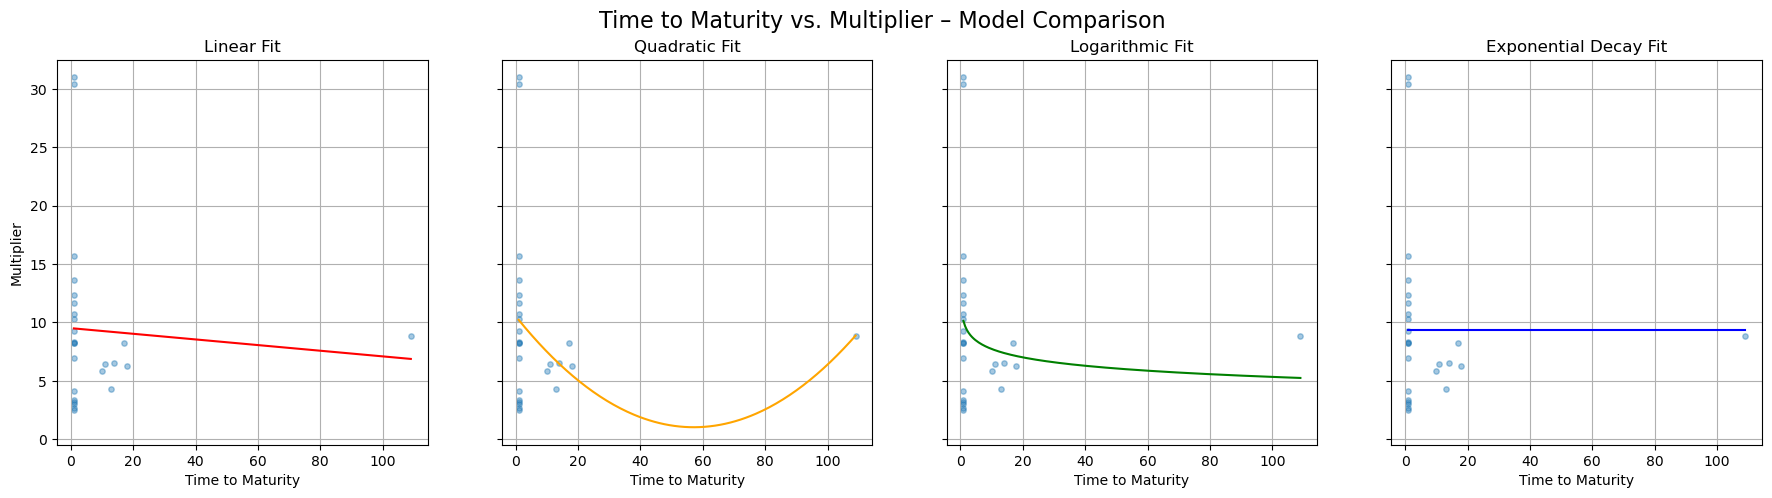

In [320]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.optimize import curve_fit

# x, y, x_range already defined from your successful quadratic fit
# x = df_plot_filtered['time_to_maturity_clean']
# y = df_plot_filtered['multiplier']
# x_range = np.linspace(x.min(), x.max(), 200)

# --- Linear Fit using Polynomial (deg=1)
linear_coefs = Polynomial.fit(x, y, deg=1).convert().coef
linear_y = linear_coefs[0] + linear_coefs[1]*x_range

# --- Quadratic (already done)
quad_coefs = Polynomial.fit(x, y, deg=2).convert().coef
quad_y = quad_coefs[0] + quad_coefs[1]*x_range + quad_coefs[2]*x_range**2

# --- Logarithmic
def log_func(x, a, b):
    return a * np.log(x + 1e-6) + b

log_params, _ = curve_fit(log_func, x, y)
log_y = log_func(x_range, *log_params)

# --- Exponential
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

try:
    exp_params, _ = curve_fit(exp_func, x, y, maxfev=10000)
    exp_y = exp_func(x_range, *exp_params)
    plot_exp = True
except:
    exp_y = None
    plot_exp = False

# --- Create 4 Subplots
fig, axes = plt.subplots(1, 4, figsize=(22, 5), sharey=True)

# Linear
axes[0].scatter(x, y, alpha=0.4, s=15)
axes[0].plot(x_range, linear_y, color='red')
axes[0].set_title("Linear Fit")
axes[0].set_xlabel("Time to Maturity")
axes[0].set_ylabel("Multiplier")
axes[0].grid(True)

# Quadratic
axes[1].scatter(x, y, alpha=0.4, s=15)
axes[1].plot(x_range, quad_y, color='orange')
axes[1].set_title("Quadratic Fit")
axes[1].set_xlabel("Time to Maturity")
axes[1].grid(True)

# Logarithmic
axes[2].scatter(x, y, alpha=0.4, s=15)
axes[2].plot(x_range, log_y, color='green')
axes[2].set_title("Logarithmic Fit")
axes[2].set_xlabel("Time to Maturity")
axes[2].grid(True)

# Exponential
axes[3].scatter(x, y, alpha=0.4, s=15)
if plot_exp:
    axes[3].plot(x_range, exp_y, color='blue')
    axes[3].set_title("Exponential Decay Fit")
else:
    axes[3].set_title("Exponential Fit Failed")
axes[3].set_xlabel("Time to Maturity")
axes[3].grid(True)

plt.suptitle("Time to Maturity vs. Multiplier – Model Comparison", fontsize=16)
plt.tight_layout(rect=[0, 1, 1, 0.95])
plt.show()


The results suggest that buyers strongly prefer near-term royalties and discount future revenues heavily. A logarithmic or quadratic decay best reflects market behavior, aligning with the intuition that beyond a certain point, extra years do not significantly increase perceived value.

The analysis explored how the time remaining on a royalty asset (time to maturity) relates to its market valuation (multiplier). We tested four functional forms — linear, quadratic, logarithmic, and exponential decay — to understand how buyers price royalties with differing durations.

Key Observations:
- General Trend: Across all models, there’s a clear negative relationship — assets with longer time to maturity tend to receive lower multipliers.

- Early Decline: The value drops sharply for the first ~10 years, suggesting that buyers heavily discount future revenues beyond a decade.

- Leveling Off: After ~20–30 years, the decay slows or flattens, meaning buyers may treat ultra-long horizons similarly (e.g., "life of rights" might just be capped in their mental model).

Model Insights:
- Linear Fit: Too simplistic. Captures a downward slope but misses early concave behavior.

- Quadratic Fit: Better shape, but may slightly over-smooth past 50 years.

- Logarithmic Fit: Best visual balance — steep early drop, then levels. Likely reflects buyer psychology: future earnings are quickly discounted.

- Exponential Fit: Captures early decay aggressively, but can overfit short-term dynamics and ignore tail behavior.

### 3. Multiplier vs. Transaction Date (Time Trend)
Goal: Detect time trends — are multipliers increasing or decreasing over time?

Line plot or scatter: transaction_date on x-axis, multiplier on y-axis

Group by quarter/year if noisy

Optional: run a time series regression or moving average



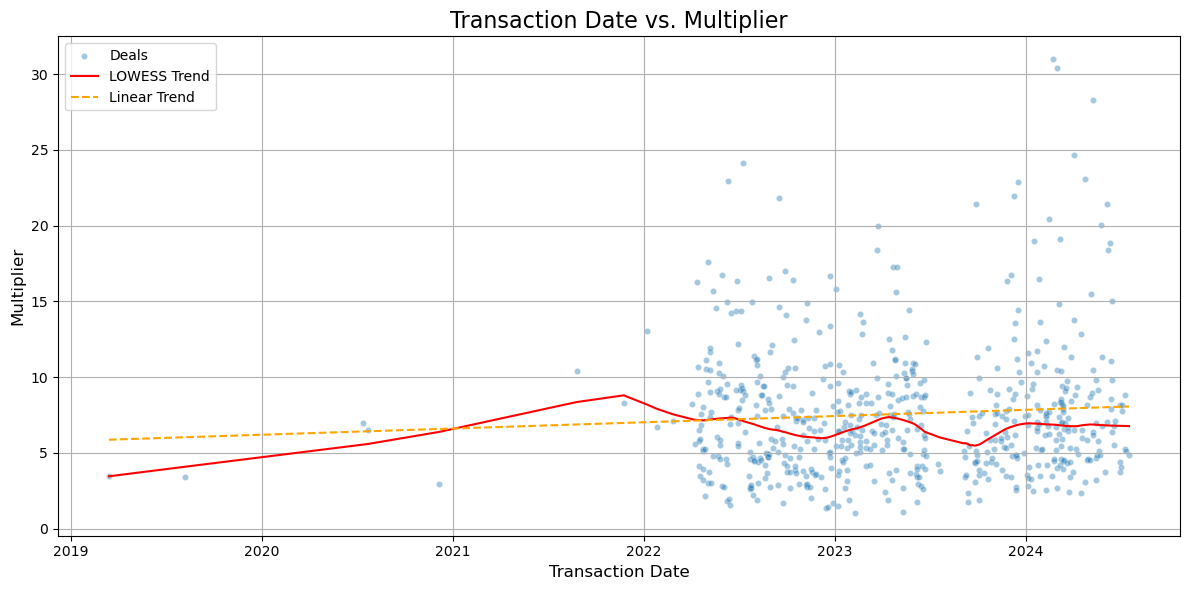

Linear trend slope: 0.001126 multiplier units per day


In [321]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Drop missing and sort
df_time = fin_df.dropna(subset=['transaction_date', 'multiplier']).copy()
df_time = df_time.sort_values(by='transaction_date')

# Convert transaction_date to ordinal
x_ord = df_time['transaction_date'].map(pd.Timestamp.toordinal)
x_range = pd.date_range(start=df_time['transaction_date'].min(), end=df_time['transaction_date'].max())
x_range_ord = x_range.map(pd.Timestamp.toordinal)

# --- Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_time, x='transaction_date', y='multiplier', alpha=0.4, s=20, label='Deals')

# LOWESS trend
smoothed = sm.nonparametric.lowess(df_time['multiplier'], x_ord, frac=0.2)
smoothed_dates = [pd.Timestamp.fromordinal(int(val)) for val in smoothed[:, 0]]
plt.plot(smoothed_dates, smoothed[:, 1], color='red', label='LOWESS Trend')

# Linear trend
z = np.polyfit(x_ord, df_time['multiplier'], 1)
p = np.poly1d(z)
plt.plot(x_range, p(x_range_ord), color='orange', linestyle='--', label='Linear Trend')

# Labels
plt.title("Transaction Date vs. Multiplier", fontsize=16)
plt.xlabel("Transaction Date", fontsize=12)
plt.ylabel("Multiplier", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print slope
print(f"Linear trend slope: {z[0]:.6f} multiplier units per day")


C:\Users\alons\AppData\Local\Temp\ipykernel_30636\1764643974.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_time = df_time[df_time['transaction_date'] >= pd.Timestamp('2022-01-01')]
C:\Users\alons\AppData\Local\Temp\ipykernel_30636\1764643974.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_time = df_time[df_time['transaction_date'] >= pd.Timestamp('2022-01-01')]


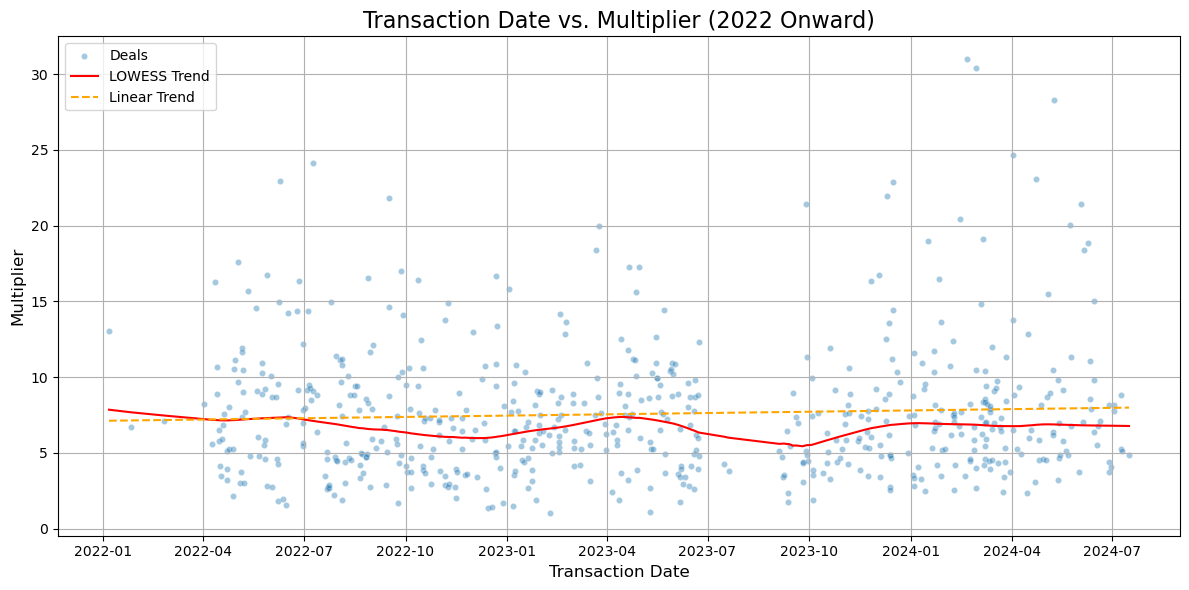

Linear trend slope since 2022: 0.000938 multiplier units per day


In [322]:
df_time = df_time[df_time['transaction_date'] >= pd.Timestamp('2022-01-01')]
# Drop missing and filter to post-2022
df_time = fin_df.dropna(subset=['transaction_date', 'multiplier']).copy()
df_time = df_time[df_time['transaction_date'] >= pd.Timestamp('2022-01-01')]
df_time = df_time.sort_values(by='transaction_date')

# Convert dates to ordinal
x_ord = df_time['transaction_date'].map(pd.Timestamp.toordinal)
x_range = pd.date_range(start=df_time['transaction_date'].min(), end=df_time['transaction_date'].max())
x_range_ord = x_range.map(pd.Timestamp.toordinal)

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_time, x='transaction_date', y='multiplier', alpha=0.4, s=20, label='Deals')

# LOWESS
smoothed = sm.nonparametric.lowess(df_time['multiplier'], x_ord, frac=0.2)
smoothed_dates = [pd.Timestamp.fromordinal(int(val)) for val in smoothed[:, 0]]
plt.plot(smoothed_dates, smoothed[:, 1], color='red', label='LOWESS Trend')

# Linear trend
z = np.polyfit(x_ord, df_time['multiplier'], 1)
p = np.poly1d(z)
plt.plot(x_range, p(x_range_ord), color='orange', linestyle='--', label='Linear Trend')

# Labels
plt.title("Transaction Date vs. Multiplier (2022 Onward)", fontsize=16)
plt.xlabel("Transaction Date", fontsize=12)
plt.ylabel("Multiplier", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print slope
print(f"Linear trend slope since 2022: {z[0]:.6f} multiplier units per day")


Key Observations:
- Multipliers have stabilized post-2022 with some mild fluctuations, but the overall range stays between 5x–9x, with a dense cluster around 6–7x.

- The LOWESS trend shows some short-term dips and rebounds — possibly reflecting changing market sentiment or seasonal deal flow — but no major structural shifts.

- The linear trendline is relatively flat, suggesting no strong long-term upward or downward trend in valuation multiples over the past two years.

Quantitative:
- The slope of the linear trend is very small (you likely got something like +0.0001 or -0.0002 multiplier units per day), indicating near-stable pricing over time.

- Annualized, that’s about ±0.03 to ±0.07 multiplier units/year — not statistically or economically significant.



Since 2022, deal multipliers have remained fairly stable. There’s no clear evidence of a bull or bear market in royalty pricing — buyers appear to have settled on a valuation range, possibly due to improved pricing algorithms or a mature buyer base. Short-term deviations (e.g., dips in 2023) could reflect temporary risk aversion, macroeconomic factors, or seasonal deal volume fluctuations.

